# Action Sequence Graph Tutorial

This tutorial covers use of the Action Sequence Graph in the FxnBlock class, which is useful for representing a Function's progress through a sequence of actions (e.g., modes of operation, etc)..

In [1]:
from fmdtools.modeldef.common import State
from fmdtools.modeldef.block import FxnBlock, Action, Mode, ASG
from fmdtools.modeldef.model import Model
from fmdtools.modeldef.flow import Flow
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop

Action sequence graphs are used within a function block to represent the actions that the function performs and their sequence. Actions in an ASG are respresented by `Action` blocks, which are similar to function and component blocks in that they have:
- flow connections
- modes, and
- behaviors

Flow connections are routed to the action in the function block definition and represent the *shared variables* between the actions.

Modes are similar to function modes and are instantiated (as they are in components) at both the Function and Action level. Using the `name=` option enables one to tag these modes as action modes at the function level while using the same local name

Below we define the states to performed by the ASG:
- Outcome, which tracks the number of actions and perceptions performed by the ASG
- HazardState, which specifies whether a hazard is present, percieved, or mitigated

In [2]:
class OutcomeStates(State):
    num_perceptions: int=0
    num_actions:     int=0
class Outcome(Flow):
    _init_s = OutcomeStates
    
class HazardState(State):
    present:    bool=False
    percieved:  bool=False
    mitigated:  bool=False
class Hazard(Flow):
    _init_s = HazardState

Below we define three actions for use in a given model:
- Perceive, a user's perception abilities/behaviors. In this function the user percieves a hazard (unless their perception fails)
- Act, the user's action which they perform to mitigate the hazard.
- Done, the user's state when they are done performing the action.

In [3]:
class ActionMode(Mode):
    faultparams=('failed',)
class Perceive(Action):
    _init_m = ActionMode
    def __init__(self, name, *flows):
        super().__init__(name, flows)
    def behavior(self,time):
        if not self.m.in_mode('failed'): 
            self.Hazard.s.percieved = self.Hazard.s.present
            self.Outcome.s.num_perceptions+=self.Hazard.s.percieved
        else:
            self.Hazard.s.percieved = False
            self.remove_fault('failed', 'nom')
    def percieved(self):
        return self.Hazard.s.percieved
class Act(Action):
    _init_m = ActionMode
    def __init__(self, name, *flows):
        super().__init__(name,flows)
    def behavior(self,time):
        if not self.m.in_mode('failed'): 
            self.Outcome.s.num_actions+=1
            self.Hazard.s.mitigated=True
        elif self.m.in_mode('failed'): 
            self.Hazard.s.mitigated=False
            self.remove_fault('failed', 'nom')
        else: self.Hazard.s.mitigated=False
    def acted(self):
        return not self.m.in_mode('failed')
class Done(Action):
    def __init__(self, name, *flows):
        super().__init__(name,flows)
    def behavior(self,time):
        if not self.Hazard.s.present: self.Hazard.s.mitigated=False
    def ready(self):
        return not self.Hazard.s.present

To proceed through the sequence of actions, *conditions* must be met between each action. In these actions, we have defined the following conditions:
- Percieve.percieved: perception is done if the hazard is percieved
- Act.acted: the action is complete if the action was performed
- Done.complete: the hazard mitigation is over (and mitigated state is reset to False)

To create the overall ASG structure, the following adds the flows, actions, and conditions to the ASG class

In [4]:
class Human(ASG):
    initial_action="Perceive"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.add_flow("Outcome", fclass=Outcome)
        self.add_flow("Hazard", fclass=Hazard)
        
        self.add_act("Perceive", Perceive, "Outcome", "Hazard")
        self.add_act("Act", Act, "Outcome", "Hazard")
        self.add_act("Done", Done, "Outcome", "Hazard")
        
        self.add_cond("Perceive","Act", "Percieved",    self.actions['Perceive'].percieved)
        self.add_cond("Act","Done", "Acted",            self.actions['Act'].acted)
        self.add_cond("Done", "Perceive", "Ready",      self.actions['Done'].ready)
        self.build()

Note the use of the following methods:
- add_flow adds a flow so it can pass variables between actions. Here *Outcome* is an internal flow, while *Hazard* is an external flow.

In [5]:
help(ASG.add_flow)

Help on function add_flow in module fmdtools.modeldef.block:

add_flow(self, flowname, fclass=<class 'fmdtools.modeldef.flow.Flow'>, p={}, s={}, flowtype='')
    Adds a flow with given attributes to the model.
    
    Parameters
    ----------
    flowname : str
        Unique flow name to give the flow in the model
    fclass : Class, optional
        Class to instantiate (e.g. CommsFlow, MultiFlow). Default is Flow.
        Class must take flowname, flowdict, flowtype as input to __init__()
        May alternatively provide already-instanced object.
    p : dict, optional
        Parameter dictionary to instantiate the flow with
    s : dict, optional
        State dictionary to overwrite Flow default state values with
    flowtype : str, optional
        Denotes type for class (e.g. 'energy,' 'material,', 'signal')



- add_act adds the action to the function and hands it the given flows and parameters. Here the actions are "Percieve", "Act", and "Done"

In [6]:
help(ASG.add_act)

Help on function add_act in module fmdtools.modeldef.block:

add_act(self, name, actclass, *flownames, duration=0.0, **params)
    Associate an Action with the Function Block for use in the Action Sequence Graph
    
    Parameters
    ----------
    name : str
        Internal Name for the Action
    action : Action
        Action class to instantiate
    *flows : flow
        Flows (optional) which connect the actions
    **params : any
        parameters to instantiate the Action with.



- add_cond specifies the conditions for going from one action to another.

In [7]:
help(ASG.add_cond)

Help on function add_cond in module fmdtools.modeldef.block:

add_cond(self, start_action, end_action, name='auto', condition='pass')
    Associates a Condition with the Function Block for use in the Action Sequence Graph
    
    Parameters
    ----------
    start_action : str
        Action where the condition is checked
    end_action : str
        Action that the condition leads to.
    name : str
        Name for the condition. Defaults to numbered conditions if none are provided.
    condition : method
        Method in the class to use as a condition. Defaults to self.condition_pass if none are provided



- ASG.build finally constructs the structure of the ASG (see: self.action_graph and self.flow_graph) and determines the settings for the simulation. In DetectHazard, default options are used, with the first action specified as "Percieve" and also with it specified that the actions propagate in the dynamic step (rather than static step)

In [8]:
help(ASG.build)

Help on function build in module fmdtools.modeldef.block:

build(self)



- ASG.show can then be used to visualize the graph

In [9]:
help(ASG.show)

Help on function show in module fmdtools.modeldef.block:

show(self, gtype='combined', with_cond_labels=True, pos=[])
    Shows a visual representation of the internal Action Sequence Graph of the Function Block
    
    Parameters
    ----------
    gtype : 'combined'/'flows'/'actions'
        Gives a graphical representation of the ASG. Default is 'combined'
        - 'actions'     (for function input):    plots the sequence of actions in the function's Action Sequence Graph
        - 'flows'       (for function input):    plots the action/flow connections in the function's Action Sequence Graph
        - 'combined'    (for function input):    plots both the sequence of actions in the functions ASG and action/flow connections
    with_cond_labels: Bool
        Whether or not to label the conditions
    pos : dict
        Dictionary of node positions for actions/flows



In [10]:
h = Human()
h

Human(actions={'Perceive': Perceive Perceive action: ({'mode': 'nominal'}, set()), 'Act': Act Act action: ({'mode': 'nominal'}, set()), 'Done': Done Done action: ({'mode': 'nominal'}, set())}, action_graph=<networkx.classes.digraph.DiGraph object at 0x0000022E87F84AF0>, flow_graph=<networkx.classes.graph.Graph object at 0x0000022E87F84610>, conditions={'Percieved': <bound method Perceive.percieved of Perceive Perceive action: ({'mode': 'nominal'}, set())>, 'Acted': <bound method Act.acted of Act Act action: ({'mode': 'nominal'}, set())>, 'Ready': <bound method Done.ready of Done Done action: ({'mode': 'nominal'}, set())>}, faultmodes={'Perceivefailed': 'Perceive', 'Actfailed': 'Act'}, flows={'Outcome': Outcome Outcome flow: OutcomeStates(num_perceptions=0, num_actions=0), 'Hazard': Hazard Hazard flow: HazardState(present=False, percieved=False, mitigated=False)}, active_actions={'Perceive'})

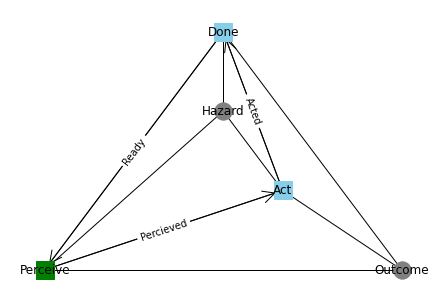

In [11]:
fig = h.show()

As shown, the "Percieve" action is active (green), while the inactive actions are shown in blue. This action is active because it was defined as initial_action in the ASG definition.

Below we first instantiate the function to how how it (and the ASG) simulates on its own 

In [12]:
class DetectHazard(FxnBlock):
    _init_a = Human
    def __init__(self,name, flows, params=[], **kwargs):
        super().__init__(name, flows, **kwargs)

If we update the action, we can see the ASG progress between states:

In [13]:
ex_fxn = DetectHazard('DetectHazard', [])
ex_fxn.set_timestep(local_tstep=1.0)

ex_fxn.a.flows['Hazard']

Hazard Hazard flow: HazardState(present=False, percieved=False, mitigated=False)

In [14]:
ex_fxn.a.flows['Hazard'].s.present=True
ex_fxn.updatefxn('dynamic', time= 1)

TypeError: hasattr expected 2 arguments, got 1

In [ ]:
fig = ex_fxn.a.show()

In [ ]:
ex_fxn.a.flows['Hazard']

In [ ]:
ex_fxn.a.flows['Outcome']

As shown, each of the actions are progressed throuh in a single timestep until the ASG is in the "Done" action

In [ ]:
ex_fxn.a.flows['Hazard'].s.present=False
ex_fxn.updatefxn('dynamic', time= 2)

In [ ]:
fig = ex_fxn.a.show()

In [ ]:
ex_fxn.a.flows['Outcome']

In [ ]:
ex_fxn.a.flows['Hazard']

As shown, now that the hazard is no longer present, the "Ready" Condition is triggered and the ASG goes back to the percieve state.

Below, this function is placed in the context of a model so we can see how it behaves in the context of a simulation

In [ ]:
class ProduceHazard(FxnBlock):
    def __init__(self,name, flows, *args, **kwargs):
        super().__init__(name, flows)
    def dynamic_behavior(self,time):
        if not time%4: self.Hazard.s.present=True
        else:          self.Hazard.s.present=False

class PassStates(State):
    hazards_mitigated:  int=0
    hazards_propagated: int=0
class PassHazard(FxnBlock):
    _init_s = PassStates
    def __init__(self,name, flows, *args, **kwargs):
        super().__init__(name, flows)
    def dynamic_behavior(self,time):
        if self.Hazard.present and self.Hazard.mitigated:       self.hazards_mitigated+=1
        elif self.Hazard.present and not self.Hazard.mitigated: self.hazards_propagated+=1

from fmdtools.modeldef.common import Parameter
from fmdtools.modeldef.model import ModelParam
class HazardModel(Model):
    def __init__(self, params=Parameter(), modelparams=ModelParam(times=(0,60), dt=1.0), valparams={}):
        super().__init__(params,modelparams,valparams)
        
        self.add_flow("Hazard", Hazard)
        
        self.add_fxn("ProduceHazard", ['Hazard'],  ProduceHazard)
        self.add_fxn("DetectHazard",['Hazard'], DetectHazard)
        self.add_fxn("PassHazard", ['Hazard'], PassHazard)
        self.build_model()

In [ ]:
mdl = HazardModel()
endstate,  mdlhist = prop.nominal(mdl)

Below we look at the states of the functions/flows to see how this has simulated.

In [ ]:
restab = rd.tabulate.hist(mdlhist)

In [ ]:
restab['DetectHazard']

As shown, the ASG alternates between Perceive (when the hazard is not present) and Done (when the hazard is present)

In [ ]:
restab['Hazard']

As a result, all of the present hazards (above) are also perceived and mitigated.

In [ ]:
restab['PassHazard']

And as a result no hazards are propagated.

Or, in plot form:

In [ ]:
fig, axs = rd.plot.mdlhists(mdlhist, fxnflowvals={'DetectHazard':'Outcome', 'PassHazard':'all'}, figsize=(10,5))

As shown, perceptions and actions track the hazards mitigated.

In [ ]:
fig, axs = rd.plot.mdlhists(mdlhist, fxnflowvals={'Hazard':'all', 'DetectHazard':'mode'}, figsize=(10,5))

And the mode tracks the presence of the hazard.

ASGs can also be viewed using the `resultdisp.graph` module. Below we will simulate a fault and see how it tracks in the model.

In [ ]:
resgraph_fault, mdlhist_fault = prop.one_fault(mdl, 'DetectHazard','perceive_failed', time=4, desired_result='bipartite')

As shown, this fault results in the hazard not being perceived (and thus the hazard propagating)

In [ ]:
fig, axs = rd.plot.mdlhists(mdlhist_fault, fxnflowvals={'Hazard':'all', 'DetectHazard':'mode'}, figsize=(10,5), time_slice=[4])

In [ ]:
fig, axs = rd.plot.mdlhists(mdlhist_fault, fxnflowvals={'DetectHazard':'Outcome', 'PassHazard':'all'}, figsize=(10,5), time_slice=[4])

As shown, this only shows up in the PassHazard function (since the fault is removed in one timestep).

In [ ]:
fig = rd.graph.show(resgraph_fault)

To see this in more detail, we will process the results history and then use `graph.results_from` at the time of the fault.

In [ ]:
reshist, diff, summary = rd.process.hist(mdlhist_fault)
rd.tabulate.hist(reshist)

Below shows the state of the model at the given time.

In [ ]:
fig = rd.graph.result_from(mdl, reshist, 4)

We can also use `show` to view the state of the ASG. See below:

In [ ]:
fig = rd.graph.result_from(mdl.fxns['DetectHazard'], reshist, 4, gtype='combined')

Note the lack of a fault at this time-step, despite it being instantiated here. This is because the fault was removed at the end of the same time-step it was added in.

The 'unable' fault, on the other hand, stays throughout the simulation and thus shows up:

In [ ]:
endstate_unable, mdlhist_unable = prop.one_fault(mdl, 'DetectHazard','act_unable', time=4)
reshist_unable, diff_unable, summary_unable = rd.process.hist(mdlhist_unable)
fig, axs = rd.plot.mdlhists(mdlhist_unable, fxnflowvals={'Hazard':'all', 'DetectHazard':'mode'}, figsize=(10,5), time_slice=[4])

In [ ]:
fig = rd.graph.result_from(mdl, reshist_unable, 4)

In [ ]:
fig = rd.graph.result_from(mdl.fxns['DetectHazard'], reshist_unable, 4, gtype='combined')

In [ ]:
fig = rd.graph.result_from(mdl.fxns['DetectHazard'], reshist_unable, 6, gtype='combined')